In [2]:
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier


import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

1. Exploring the Data

1.1 length, variable, type and null check

1.2 dependent variable check (ratio, distribution..)

1.3 explainable variable check (trend analysis)  
1.3.1 describe() - mean, median..  
1.3.2 Sample Analysis  
1.3.3. visualization (correlation, skewness)  
1.3.4. skewed -> feature engineering(scaling, transformation ; log)  
1.3.5. re-visualization (correlation, skewness)  

1.4 explainable variable check (Outlier check) -> 제거

1.5 상관계수 및 그래프

1.3 trend analysis
1.4 correlation



1. 고객들이 불편함을 겪지 않도록 자전거를 많이 확보해 두는 것
2. 최대한 많은 registered 유저들을 확보하여 안정적인 수요 예측과 매출 달성
  * casual - registered 패턴이 유사한 고객에 한해서는 등록 홍보
  * casual - registered 패턴이 다른 고객에게는 새로운 promotion 개시

# Exploring the Data

In [3]:
path = 'E:\\unist\\skt\\'
data = pd.read_csv(path+'bike.csv')
data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [22]:
fmri = sns.load_dataset("fmri")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


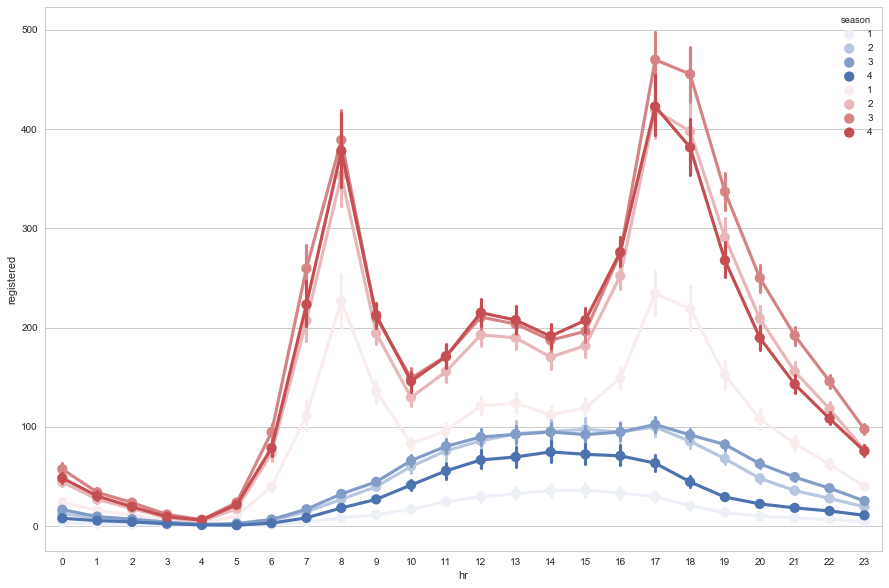

In [35]:
fig, ax = plt.subplots(figsize=(15,10))
sns.pointplot(x='hr', y='casual', data=data, ax=ax, color='b', hue='season')
sns.pointplot(x='hr', y='registered', data=data, ax=ax, color='r', hue='season')
plt.show()

casual 유저들은 낮시간대~저녁시간대에 주로 사용하는 반면, registered 유저는 출퇴근 시간대(7-9, 4-7)에 자전거를 많이 이용함
-> casual 유저 사용 시간과 registered 유저 사용시간이 겹치는 시간대에 자전거를 많이 확보하는 것이 중요

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


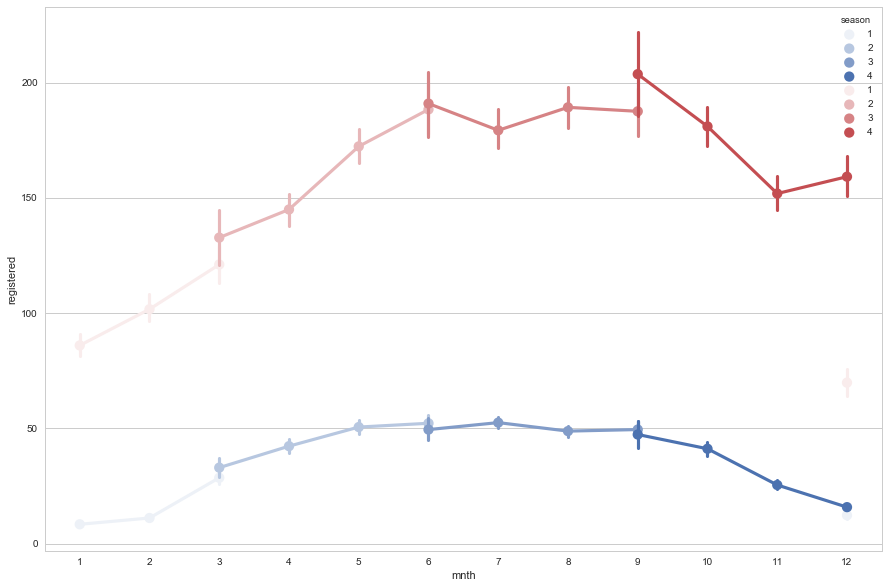

In [45]:
fig, ax = plt.subplots(figsize=(15,10))
sns.pointplot(x='mnth', y='casual', data=data, ax=ax, color='b', hue='season')
sns.pointplot(x='mnth', y='registered', data=data, ax=ax, color='r', hue='season')
plt.show()

1. 일반적인 4계절 구분과는 다른 것 같음. 계절이 아니라 월을 사용하도록 함.
2. 1-2월에는 자전거 사용량이 급격히 감소하는데, 그 이유를 알아보고자 함

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


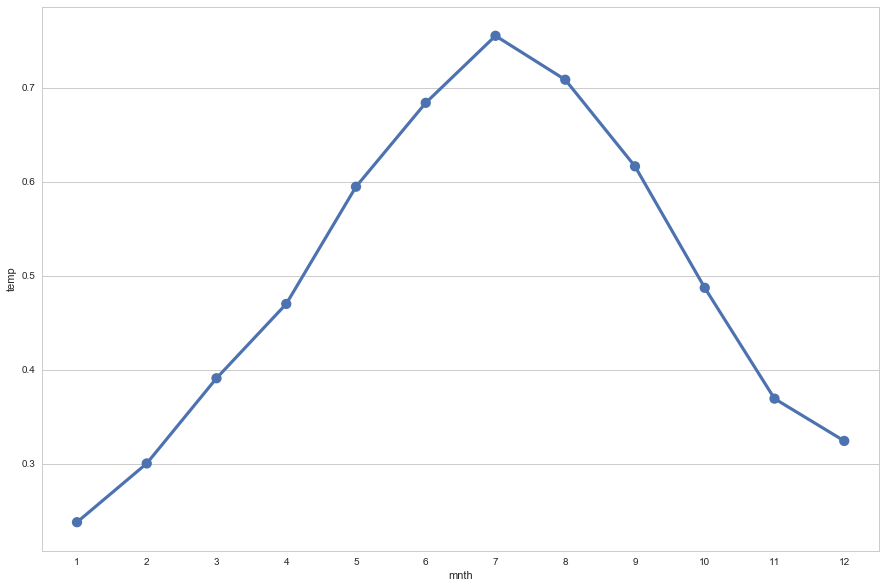

In [67]:
fig, ax = plt.subplots(figsize=(15,10))
d = data.groupby('mnth').mean().reset_index()
sns.pointplot(x='mnth', y='temp', data=d, ax=ax, color='b')
plt.show()

In [55]:
data[data['mnth']==1].describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,1429.000000,1429.0,1429.000000,1429.0,1429.000000,1429.000000,1429.000000,1429.00000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000
mean,4841.058083,1.0,0.518544,1.0,11.696991,0.049685,2.869839,0.63471,1.456963,0.237649,0.240676,0.580931,0.207551,8.426872,85.997901,94.424773
std,4339.212256,0.0,0.499831,0.0,6.898412,0.217370,2.068131,0.48168,0.642018,0.099911,0.097280,0.188197,0.125727,15.151606,91.807469,99.907146
min,1.000000,1.0,0.000000,1.0,0.000000,0.000000,0.000000,0.00000,1.000000,0.020000,0.000000,0.210000,0.000000,0.000000,0.000000,1.000000
25%,358.000000,1.0,0.000000,1.0,6.000000,0.000000,1.000000,0.00000,1.000000,0.160000,0.181800,0.440000,0.104500,1.000000,20.000000,21.000000
50%,8672.000000,1.0,1.000000,1.0,12.000000,0.000000,3.000000,1.00000,1.000000,0.220000,0.227300,0.550000,0.194000,4.000000,59.000000,66.000000
75%,9029.000000,1.0,1.000000,1.0,18.000000,0.000000,5.000000,1.00000,2.000000,0.300000,0.287900,0.740000,0.283600,10.000000,118.000000,128.000000
max,9386.000000,1.0,1.000000,1.0,23.000000,1.000000,6.000000,1.00000,4.000000,0.580000,0.545500,1.000000,0.656700,156.000000,518.000000,559.000000


In [56]:
data[data['mnth']==9].describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,1437.000000,1437.000000,1437.000000,1437.0,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000,1437.000000
mean,10476.901879,3.267223,0.501044,9.0,11.519833,0.033403,3.051496,0.665971,1.488518,0.616507,0.579344,0.714454,0.165856,48.937370,191.835769,240.773138
std,4390.172362,0.442664,0.500173,0.0,6.918078,0.179749,2.030099,0.471814,0.671267,0.081386,0.073558,0.168580,0.108296,59.827156,177.809699,214.609531
min,5726.000000,3.000000,0.000000,9.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.380000,0.393900,0.280000,0.000000,0.000000,0.000000,1.000000
25%,6085.000000,3.000000,0.000000,9.0,6.000000,0.000000,1.000000,0.000000,1.000000,0.560000,0.515200,0.600000,0.089600,7.000000,51.000000,60.000000
50%,14493.000000,3.000000,1.000000,9.0,12.000000,0.000000,3.000000,1.000000,1.000000,0.620000,0.575800,0.730000,0.164200,28.000000,151.000000,190.000000
75%,14852.000000,4.000000,1.000000,9.0,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.840000,0.253700,65.000000,266.000000,355.000000
max,15211.000000,4.000000,1.000000,9.0,23.000000,1.000000,6.000000,1.000000,3.000000,0.860000,0.787900,1.000000,0.641800,350.000000,886.000000,977.000000


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


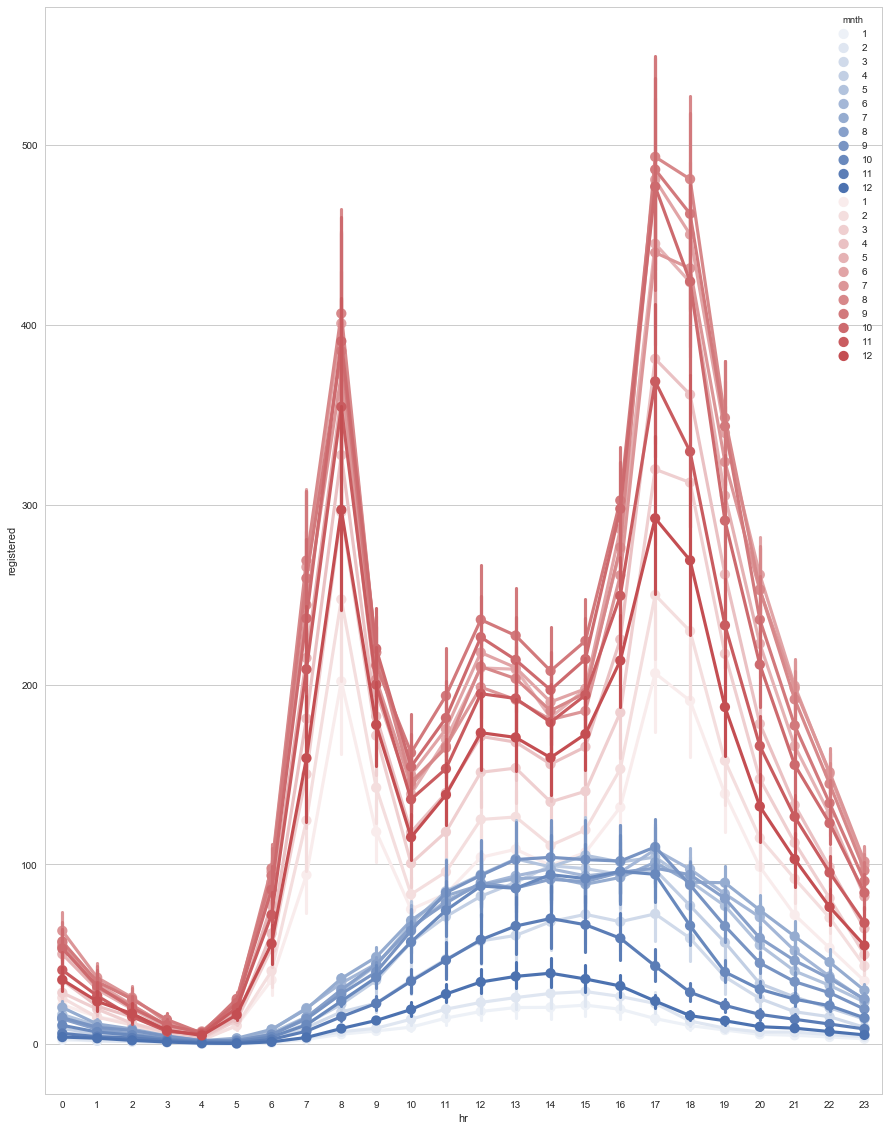

In [47]:
fig, ax = plt.subplots(figsize=(15,20))
sns.pointplot(x='hr', y='casual', data=data, ax=ax, color='b', hue='mnth')
sns.pointplot(x='hr', y='registered', data=data, ax=ax, color='r', hue='mnth')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


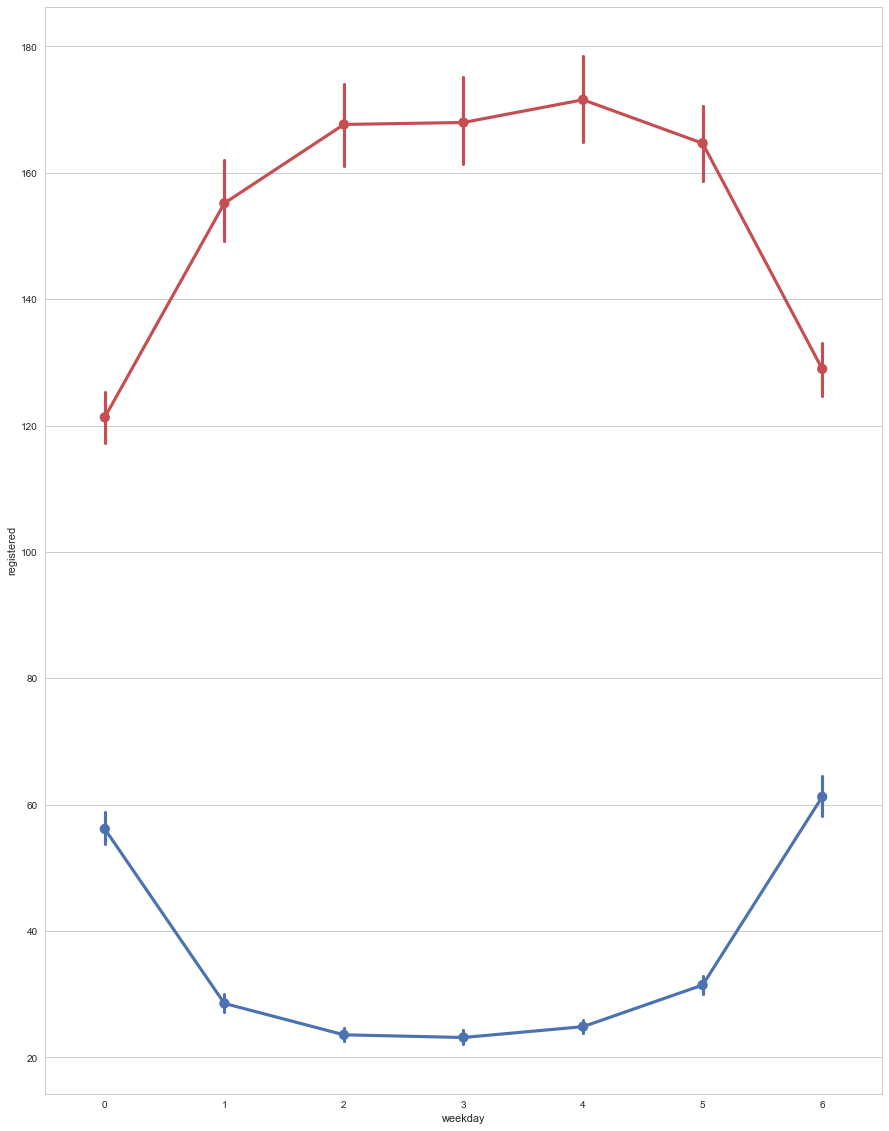

In [70]:
fig, ax = plt.subplots(figsize=(15,20))
sns.pointplot(x='weekday', y='casual', data=data, ax=ax, color='b',)
sns.pointplot(x='weekday', y='registered', data=data, ax=ax, color='r',)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


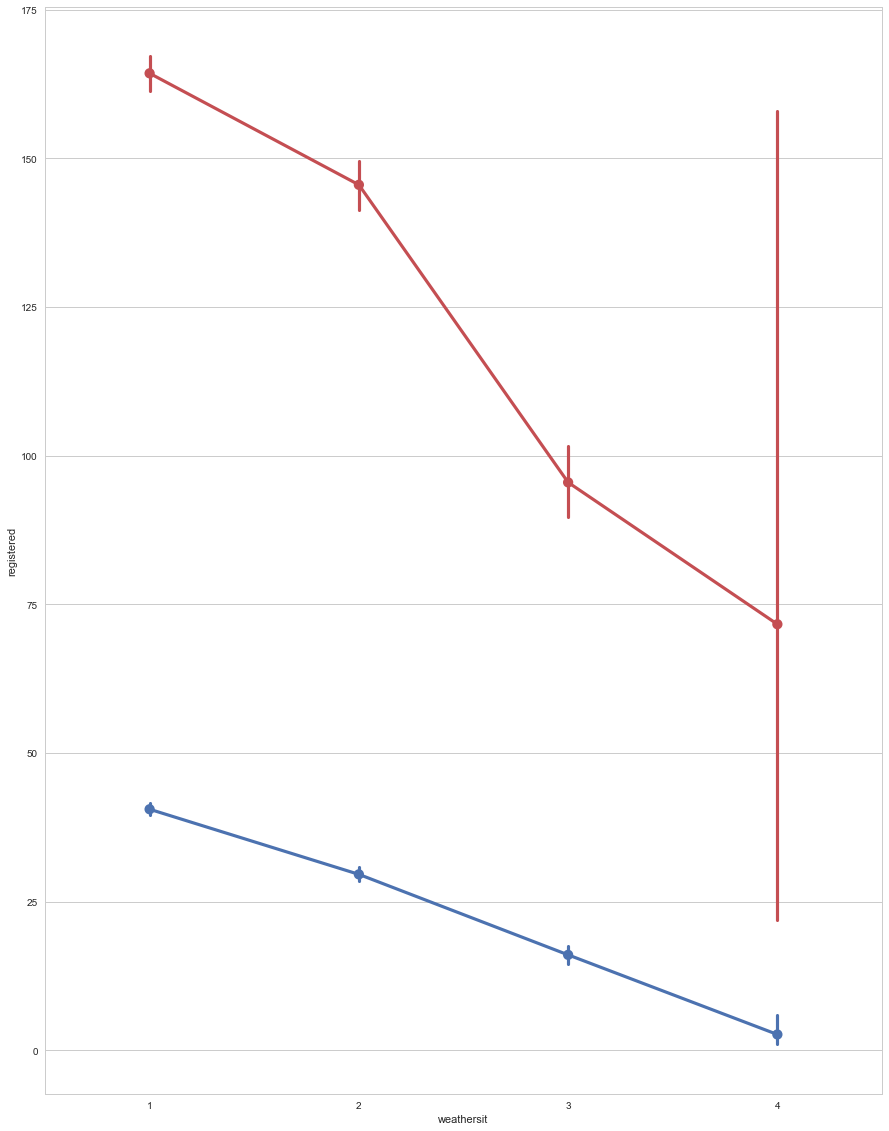

In [74]:
fig, ax = plt.subplots(figsize=(15,20))
sns.pointplot(x='weathersit', y='casual', data=data, ax=ax, color='b',)
sns.pointplot(x='weathersit', y='registered', data=data, ax=ax, color='r',)
plt.show()

1. casual은 주말에 사용량이 높고, registered는 평일에 사용량이 높음

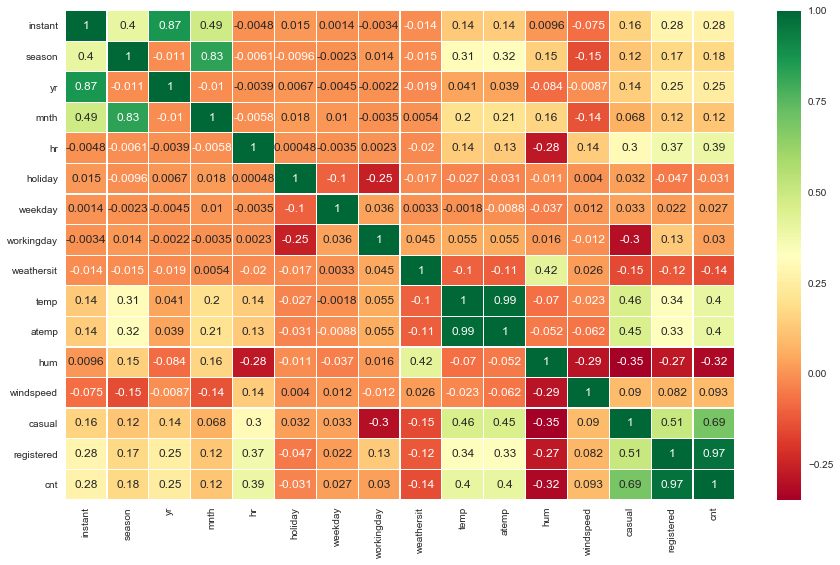

In [50]:
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()

fig.set_size_inches(15,9)
plt.show()

1. atemp와 temp간 강한 상관관계 -> 상관계수가 조금 더 높은 atemp를 사용하도로ㄱ 한다
2. casual의 경우 workingday 여부와 음의 상관관계를 나타냄. 
registered 고객과는 다름은 주목할만한 것.
casual 유저들은 workingday에 자전거를 거의 이용하지 않지만 registered 유저는 workingday에도 자전거를 이용함
3. 양쪽 모두 온도에 영향을 받지만 casual의 경우 registered 유저보다 조금 더 많은 영향을 받음
-> casual의 경우 registered보다 환경의 영향을 더 많이 받음을 알 수 있음
4. windspeed에는 거의 영향을 받지 않는데, 이는 사람이 느끼는 풍속의 정도가 미미

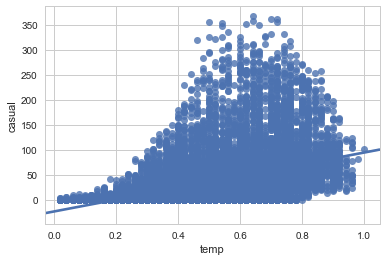

In [43]:
sns.regplot('temp', 'casual', data=data, )

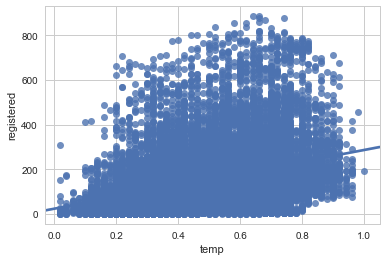

In [44]:
sns.regplot('temp', 'registered', data=data, )

In [37]:
data[data['season']==1].describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,4242.000000,4242.0,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000
mean,6302.008015,1.0,0.512494,3.119755,11.648515,0.038661,3.008722,0.658652,1.460160,0.299147,0.298116,0.581348,0.215107,14.290901,96.823668,111.114569
std,5028.056396,0.0,0.499903,3.411534,6.899606,0.192808,2.037880,0.474218,0.653247,0.118726,0.114405,0.199403,0.136914,27.463006,104.347605,119.224010
min,1.000000,1.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1061.250000,1.0,0.000000,1.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.220000,0.212100,0.430000,0.104500,1.000000,21.000000,23.000000
50%,8698.500000,1.0,1.000000,2.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.280000,0.287900,0.560000,0.194000,5.000000,66.000000,76.000000
75%,9758.750000,1.0,1.000000,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.360000,0.378800,0.740000,0.298500,15.000000,135.000000,158.000000
max,17379.000000,1.0,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,0.720000,0.651500,1.000000,0.806000,367.000000,681.000000,801.000000


In [39]:
data[data['season']==4].describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,4232.000000,4232.0,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000,4232.000000
mean,11655.779301,4.0,0.495747,10.702505,11.522448,0.034026,2.979915,0.676749,1.472117,0.423138,0.415738,0.667124,0.170819,30.666824,168.202032,198.868856
std,4418.306229,0.0,0.500041,0.918886,6.923253,0.181319,2.005858,0.467773,0.653104,0.122167,0.109336,0.178149,0.118666,46.034058,157.559340,182.967972
min,6251.000000,4.0,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.140000,0.151500,0.160000,0.000000,0.000000,0.000000,1.000000
25%,7308.750000,4.0,0.000000,10.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.320000,0.333300,0.530000,0.089600,4.000000,41.000000,46.000000
50%,8366.500000,4.0,0.000000,11.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.420000,0.424200,0.660000,0.164200,14.000000,134.000000,155.500000
75%,16059.250000,4.0,1.000000,11.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.520000,0.500000,0.820000,0.253700,36.000000,235.250000,295.000000
max,17117.000000,4.0,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,3.000000,0.760000,0.681800,1.000000,0.641800,362.000000,876.000000,967.000000


In [38]:
data[data['season']!=1].describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,13137.000000,13137.000000,13137.000000,13137.000000,13137.000000,13137.000000,13137.000000,13137.000000,13137.000000,13137.000000,13137.000000,13137.000000,13137.000000,13137.000000,13137.000000,13137.000000
mean,9461.094009,2.986527,0.499353,7.641471,11.513892,0.025577,3.002055,0.690493,1.414021,0.560871,0.533142,0.642044,0.182022,42.581640,172.180559,214.762198
std,4764.514900,0.810943,0.500019,2.625900,6.919120,0.157874,1.995369,0.462308,0.634423,0.166671,0.146151,0.188429,0.116109,52.698644,159.390923,190.564327
min,1808.000000,2.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.140000,0.151500,0.160000,0.000000,0.000000,0.000000,1.000000
25%,5092.000000,2.000000,0.000000,5.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.420000,0.424200,0.490000,0.104500,6.000000,43.000000,52.000000
50%,8376.000000,3.000000,0.000000,8.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.580000,0.545500,0.650000,0.164200,25.000000,138.000000,174.000000
75%,13833.000000,4.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.700000,0.636400,0.790000,0.253700,58.000000,243.000000,317.000000
max,17117.000000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,3.000000,1.000000,1.000000,1.000000,0.850700,362.000000,886.000000,977.000000


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


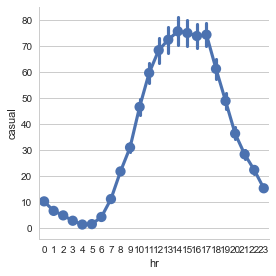

In [21]:
plt.figure(figsize=(10,6))
sns.factorplot(x ='hr', y='casual', data=data,  kind='point')

In [68]:
data.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [76]:
df = data.drop(['instant', 'dteday', 'season', 'yr', 'mnth', 'atemp', 'windspeed', 'cnt'], axis=1)

In [100]:
import numpy as np
import pandas as pd

import xgboost
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

from time import time

from sklearn.cross_validation import train_test_split
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display

%matplotlib inline

In [88]:
df.head()

,hr,holiday,weekday,workingday,weathersit,temp,hum,casual,registered
0,0,0,6,0,1,0.24,0.81,3,13
1,1,0,6,0,1,0.22,0.80,8,32
2,2,0,6,0,1,0.22,0.80,5,27
3,3,0,6,0,1,0.24,0.75,3,10
4,4,0,6,0,1,0.24,0.75,0,1


In [89]:
df.reset_index(drop=True, inplace=True)

In [90]:
con_var = ['temp', 'hum', 'casual', 'registered']
cat_var = ['hr', 'weekday', 'workingday', 'holiday', 'weathersit']

In [93]:
df[cat_var] = df[cat_var].astype(str)
con = df[con_var]
cat = pd.get_dummies(df[cat_var], prefix=cat_var, drop_first=True)
D = pd.concat([con, cat], axis=1)
D.head()

,temp,hum,casual,registered,hr_1,hr_10,hr_11,hr_12,hr_13,hr_14,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,holiday_1,weathersit_2,weathersit_3,weathersit_4
0,0.24,0.81,3,13,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0.22,0.80,8,32,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.22,0.80,5,27,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.24,0.75,3,10,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0.24,0.75,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [95]:
X = D.drop(['casual', 'registered'], axis=1)
y = D['casual']
yc = D['registered']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 13903 samples.
Testing set has 3476 samples.


In [83]:
data.dtypes

age                 int64
workclass          object
education_level    object
education-num       int64
marital-status     object
occupation         object
relationship       object
race               object
sex                object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
income             object
dtype: object

In [101]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
learning_rate = [0.01, 0.05, 0.1]
max_depth = [3, 4, 5]
subsample = [0.7, 0.8, 0.9]
colsample_bytree = [0.5, 0.8]
gamma = [0, 1, 5]
random_grid = {'n_estimators': n_estimators,
               'learning_rate' : learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'colsample_bytree': colsample_bytree,
               'gamma': gamma}

xgb = xgboost.XGBRegressor(random_state = 100)
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=1)
xgb_random.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] subsample=0.8, n_estimators=800, max_depth=5, learning_rate=0.01, gamma=1, colsample_bytree=0.8 
[CV]  subsample=0.8, n_estimators=800, max_depth=5, learning_rate=0.01, gamma=1, colsample_bytree=0.8, total=  12.3s
[CV] subsample=0.8, n_estimators=800, max_depth=5, learning_rate=0.01, gamma=1, colsample_bytree=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.8s remaining:    0.0s


[CV]  subsample=0.8, n_estimators=800, max_depth=5, learning_rate=0.01, gamma=1, colsample_bytree=0.8, total=  12.2s
[CV] subsample=0.8, n_estimators=800, max_depth=5, learning_rate=0.01, gamma=1, colsample_bytree=0.8 
[CV]  subsample=0.8, n_estimators=800, max_depth=5, learning_rate=0.01, gamma=1, colsample_bytree=0.8, total=  12.5s
[CV] subsample=0.7, n_estimators=300, max_depth=4, learning_rate=0.1, gamma=1, colsample_bytree=0.8 
[CV]  subsample=0.7, n_estimators=300, max_depth=4, learning_rate=0.1, gamma=1, colsample_bytree=0.8, total=   3.0s
[CV] subsample=0.7, n_estimators=300, max_depth=4, learning_rate=0.1, gamma=1, colsample_bytree=0.8 
[CV]  subsample=0.7, n_estimators=300, max_depth=4, learning_rate=0.1, gamma=1, colsample_bytree=0.8, total=   3.5s
[CV] subsample=0.7, n_estimators=300, max_depth=4, learning_rate=0.1, gamma=1, colsample_bytree=0.8 
[CV]  subsample=0.7, n_estimators=300, max_depth=4, learning_rate=0.1, gamma=1, colsample_bytree=0.8, total=   4.1s
[CV] subsampl

[CV]  subsample=0.9, n_estimators=400, max_depth=4, learning_rate=0.01, gamma=0, colsample_bytree=0.8, total=   4.6s
[CV] subsample=0.9, n_estimators=400, max_depth=4, learning_rate=0.01, gamma=0, colsample_bytree=0.8 
[CV]  subsample=0.9, n_estimators=400, max_depth=4, learning_rate=0.01, gamma=0, colsample_bytree=0.8, total=   4.7s
[CV] subsample=0.9, n_estimators=400, max_depth=4, learning_rate=0.01, gamma=0, colsample_bytree=0.8 
[CV]  subsample=0.9, n_estimators=400, max_depth=4, learning_rate=0.01, gamma=0, colsample_bytree=0.8, total=   4.9s
[CV] subsample=0.8, n_estimators=900, max_depth=3, learning_rate=0.1, gamma=0, colsample_bytree=0.8 
[CV]  subsample=0.8, n_estimators=900, max_depth=3, learning_rate=0.1, gamma=0, colsample_bytree=0.8, total=   9.0s
[CV] subsample=0.8, n_estimators=900, max_depth=3, learning_rate=0.1, gamma=0, colsample_bytree=0.8 
[CV]  subsample=0.8, n_estimators=900, max_depth=3, learning_rate=0.1, gamma=0, colsample_bytree=0.8, total=   9.0s
[CV] subsam

[CV]  subsample=0.9, n_estimators=900, max_depth=3, learning_rate=0.05, gamma=1, colsample_bytree=0.8, total=   5.8s
[CV] subsample=0.9, n_estimators=500, max_depth=5, learning_rate=0.1, gamma=0, colsample_bytree=0.8 
[CV]  subsample=0.9, n_estimators=500, max_depth=5, learning_rate=0.1, gamma=0, colsample_bytree=0.8, total=   5.9s
[CV] subsample=0.9, n_estimators=500, max_depth=5, learning_rate=0.1, gamma=0, colsample_bytree=0.8 
[CV]  subsample=0.9, n_estimators=500, max_depth=5, learning_rate=0.1, gamma=0, colsample_bytree=0.8, total=   5.0s
[CV] subsample=0.9, n_estimators=500, max_depth=5, learning_rate=0.1, gamma=0, colsample_bytree=0.8 
[CV]  subsample=0.9, n_estimators=500, max_depth=5, learning_rate=0.1, gamma=0, colsample_bytree=0.8, total=   5.7s
[CV] subsample=0.7, n_estimators=800, max_depth=4, learning_rate=0.1, gamma=0, colsample_bytree=0.5 
[CV]  subsample=0.7, n_estimators=800, max_depth=4, learning_rate=0.1, gamma=0, colsample_bytree=0.5, total=   6.8s
[CV] subsample=

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  9.2min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=100,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=30, n_jobs=1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 4, 5], 'subsample': [0.7, 0.8, 0.9], 'colsample_bytree': [0.5, 0.8], 'gamma': [0, 1, 5]},
          pre_dispatch='2*n_jobs', random_state=1, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [106]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor(random_state = 100)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=4, max_depth=110, bootstrap=True 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=4, max_depth=110, bootstrap=True, total=  31.8s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=4, max_depth=110, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   33.3s remaining:    0.0s


[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=4, max_depth=110, bootstrap=True, total=  33.3s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=4, max_depth=110, bootstrap=True 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=4, max_depth=110, bootstrap=True, total=  32.9s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_depth=50, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_depth=50, bootstrap=True, total=  51.9s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_depth=50, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_depth=50, bootstrap=True, total=  52.0s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_depth=50, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_depth=50, bootstrap=True, total=  51.7s
[CV] n_estimators=600, min_samples_split=2, min_samples_leaf=

[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_depth=110, bootstrap=True, total=   8.2s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_depth=110, bootstrap=True 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_depth=110, bootstrap=True, total=   6.6s
[CV] n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_depth=110, bootstrap=True 
[CV]  n_estimators=300, min_samples_split=10, min_samples_leaf=2, max_depth=110, bootstrap=True, total=   6.6s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_depth=80, bootstrap=True, total=  17.4s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_depth=80, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_depth=80, bootstrap=True, total=  17.6s
[CV] n_estimators=800, min_samples_split=2, min_samples_leaf=4, max_d

[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_depth=60, bootstrap=True, total=  17.7s
[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_depth=60, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=4, max_depth=60, bootstrap=True, total=  17.7s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_depth=30, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_depth=30, bootstrap=False, total=  13.4s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_depth=30, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_depth=30, bootstrap=False, total=  13.2s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_depth=30, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_depth=30, bootstrap=False, total=  13.4s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=2, ma

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 34.1min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=100, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=30, n_jobs=1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=1, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [155]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

In [161]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    
    results = {}
    learner = learner.fit(X_train,y_train)

    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)

    results['acc_train'] = rmsle(y_train,predictions_train)
    results['acc_test'] = rmsle(y_test,predictions_test)

    return results

In [162]:
def rmsle(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: #check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

In [163]:
clf_A = rf_random.best_estimator_
clf_B = xgb_random.best_estimator_
clf_C = lgb.LGBMClassifier(random_state = 11)

results = {}
for clf in [clf_A, clf_B]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    results[clf_name] = train_predict(clf, X_train, y_train, X_test, y_test)

KeyError: 8

In [151]:
def evaluate(results):

    fig, ax = plt.subplots(1, 2, figsize = (10,7))

    bar_width = 0.15
    colors = ['#A00000','#00A0A0','#00A000']
    
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['acc_train',  'acc_test',]):
            # Creative plot code
            ax[int(j/1)].bar(k*bar_width, results[learner][metric], width = bar_width, color = colors[k])
            
    ax[0].set_ylabel("Accuracy Score")
    
    ax[0].set_title("Accuracy Score on Training Subset")
    ax[1].set_title("Accuracy Score on Testing Set")


    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.15, 1.5), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

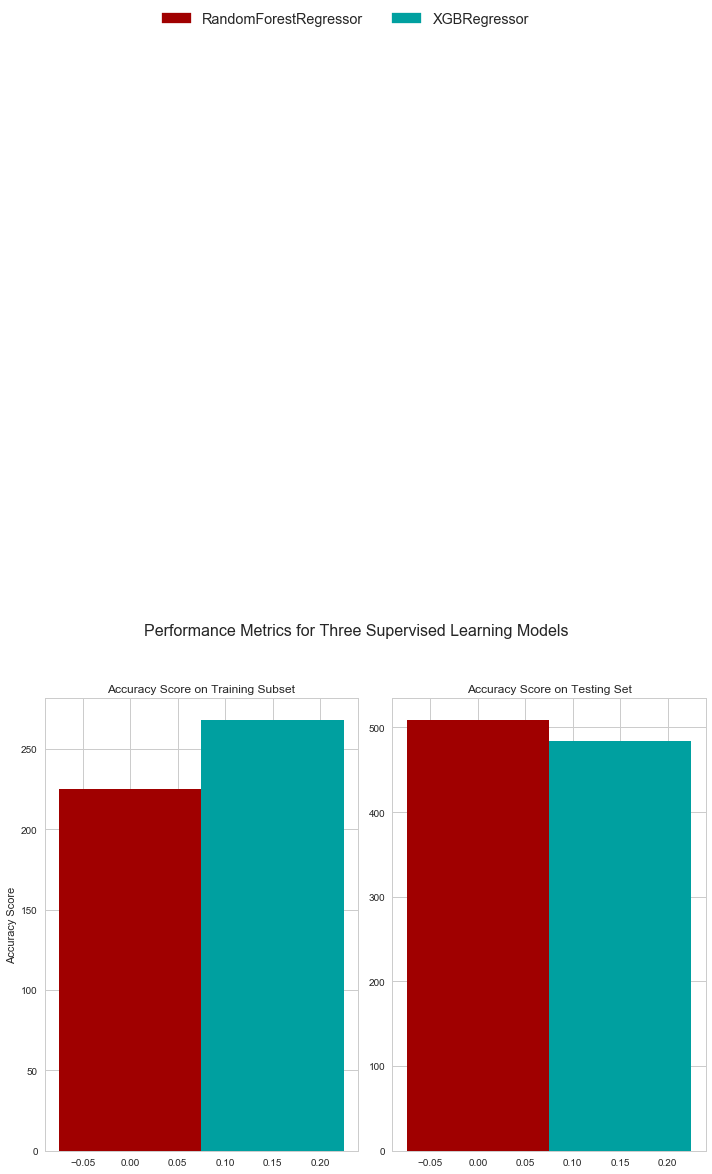

In [152]:
evaluate(results)

In [148]:
plt.figure(figsize=(10,6))
pd.DataFrame({'importance':clf_B.feature_importances_, 'columns':X.columns}).sort_values('importance', ascending=False)

,importance,columns
0,0.272287,temp
1,0.252805,hum
31,0.084876,workingday_1
30,0.043179,weekday_6
33,0.031102,weathersit_2
29,0.028881,weekday_5
34,0.025691,weathersit_3
32,0.016975,holiday_1
25,0.016292,weekday_1
4,0.014981,hr_11


In [7]:
# OPTIONAL: Select the indices for data points you wish to remove
outliers  = []

# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature],25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature],75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3-Q1) * 1.5
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    out = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    display(out)
    outliers = outliers + list(out.index.values)
    

#Creating list of more outliers which are the same for multiple features.
outliers = list(set([x for x in outliers if outliers.count(x) > 1]))    

print "Outliers: {}".format(outliers)

# Remove the outliers, if any were specified 
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)
print "The good dataset now has {} observations after removing outliers.".format(len(good_data))

SyntaxError: invalid syntax (<ipython-input-7-33e20d8b8b88>, line 17)